In [1]:
import os
# set wd to cancer
os.chdir("/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff")
print(os.getcwd())

/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff


In [31]:
import os
import sys
import math
import copy
import logging
import requests
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from itertools import chain
from typing import Union

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

from pytorch_lightning import LightningModule, Trainer
from omegaconf import DictConfig, OmegaConf
from omegaconf.errors import MissingMandatoryValue

import ray
from ray import tune, ray_constants

import hydra
from hydra import initialize, compose
from hydra.utils import instantiate

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.core.interactiveshell import InteractiveShell

from src.data import RealDatasetCollection, SyntheticDatasetCollection
from src.models import TimeVaryingCausalModel
from src.models.CausalDiff import *
from src.models.utils import (
    grad_reverse,
    BRTreatmentOutcomeHead,
    AlphaRise,
    clip_normalize_stabilized_weights,
)
from src.models.utils_lstm import VariationalLSTM
from copy import deepcopy

InteractiveShell.ast_node_interactivity = "all"

In [32]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available. No GPUs detected.")

2.0.0+cu118
11.8
Number of available GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe


## Collecting and preparing data


In [33]:
logger = logging.getLogger(__name__)


class CausalDiff(TimeVaryingCausalModel):

    model_type = None  # Will be defined in subclasses
    possible_model_types = {'msm_regressor',
                            'propensity_treatment', 'propensity_history'}

    def __init__(
        self,
        args: DictConfig,
        dataset_collection: Union[
            RealDatasetCollection, SyntheticDatasetCollection
        ] = None,
        autoregressive: bool = None,
        has_vitals: bool = None,
        projection_horizon: int = None,
        bce_weights: np.array = None,
        **kwargs
    ):
        """
        Args:args: DictConfig of model hyperparameters
            dataset_collection: Dataset collection
            autoregressive: Flag of including previous outcomes to modelling
            has_vitals: Flag of vitals in dataset
            projection_horizon: Range of tau-step-ahead prediction (tau = projection_horizon + 1)
            bce_weights: Re-weight BCE if used
            **kwargs: Other arguments
        """
        super().__init__(
            args, dataset_collection, autoregressive, has_vitals, bce_weights
        )

        if self.dataset_collection is not None:
            self.projection_horizon = self.dataset_collection.projection_horizon
        else:
            self.projection_horizon = projection_horizon

        self.lag_features = args.model.lag_features

    def prepare_data(self) -> None:
        if (
            self.dataset_collection is not None
            and not self.dataset_collection.processed_data_multi
        ):
            self.dataset_collection.process_data_multi()

    def get_exploded_dataset(self, dataset: Dataset, min_length: int, only_active_entries=True, max_length=None) -> Dataset:
        exploded_dataset = deepcopy(dataset)
        if max_length is None:
            max_length = max(exploded_dataset.data['sequence_lengths'][:])
        if not only_active_entries:
            exploded_dataset.data['active_entries'][:, :, :] = 1.0
            exploded_dataset.data['sequence_lengths'][:] = max_length
        exploded_dataset.explode_trajectories(min_length)
        return exploded_dataset

    def get_propensity_scores(self, dataset: Dataset) -> np.array:
        logger.info(f'Propensity scores for {dataset.subset_name}.')
        exploded_dataset = self.get_exploded_dataset(
            dataset, min_length=self.lag_features, only_active_entries=False)

        inputs = self.get_inputs(exploded_dataset)
        classifier = getattr(self, self.model_type)

        propensity_scores = np.stack(
            classifier.predict_proba(inputs), 1)[:, :, 1]
        propensity_scores = propensity_scores.reshape(dataset.data['active_entries'].shape[0],
                                                      dataset.data['active_entries'].shape[1] -
                                                      self.lag_features,
                                                      self.dim_treatments)
        propensity_scores = np.concatenate([0.5 * np.ones((propensity_scores.shape[0], self.lag_features, self.dim_treatments)),
                                            propensity_scores], axis=1)
        return propensity_scores

    # def get_propensity_scores(self, classifier, inputs, dataset: Dataset) -> np.array:
    #     logger.info(f'Propensity scores for {dataset.subset_name}.')

    #     propensity_scores = np.stack(
    #         classifier.predict_proba(inputs), 1)[:, :, 1]
    #     propensity_scores = propensity_scores.reshape(dataset.data['active_entries'].shape[0],
    #                                                   dataset.data['active_entries'].shape[1] -
    #                                                   self.lag_features,
    #                                                   self.dim_treatments)
    #     propensity_scores = np.concatenate([0.5 * np.ones((propensity_scores.shape[0], self.lag_features, self.dim_treatments)),
    #                                         propensity_scores], axis=1)
    #     return propensity_scores

In [34]:
# # Load the configuration file
# config_path = '/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff/config/cancer_sim_notebook.yaml'
# args = OmegaConf.load(config_path)

In [35]:
# Instantiate the dataset collection
# dataset_collection = instantiate(args.dataset, _recursive_=True)

In [36]:
# # Create an instance of CausalDiff
# causal_diff = CausalDiff(args, dataset_collection)

# # Test the prepare_data method
# causal_diff.prepare_data()

# # Test the get_exploded_dataset method
# exploded_dataset = causal_diff.get_exploded_dataset(
#     causal_diff.dataset_collection.train_f, min_length=args.model.min_length
# )

In [37]:
# for key in causal_diff.dataset_collection.test_cf_one_step.data.keys():
#     print(key, causal_diff.dataset_collection.test_cf_one_step.data[key][0])
#     print(
#         key, causal_diff.dataset_collection.test_cf_one_step.data[key][0].shape)

In [38]:
# exploded_dataset.data['outputs'].shape

In [39]:
# for key in exploded_dataset.data.keys():
#     print(key, exploded_dataset.data[key][0])
#     print(key, exploded_dataset.data[key][0].shape)

## Calculating weights


In [40]:
# Load the configuration file
config_path = '/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff/config/cancer_sim_notebook.yaml'
args = OmegaConf.load(config_path)

In [41]:
# Instantiate the dataset collection
dataset_collection = instantiate(args.dataset, _recursive_=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff/src/data/cancer_sim/cancer_simulation.py:346: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
  1%|          | 88/10000 [00:00<00:11, 879.26it/s]

 31%|███       | 31/100 [00:02<00:05, 13.69it/s]/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff/src/data/cancer_sim/cancer_simulation.py:39: RuntimeWarning: invalid value encountered in scalar power
  return ((volume / (4 / 3 * np.pi)) ** (1 / 3)) * 2
100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


Call to simulate counterfactuals data


100%|██████████| 100/100 [00:02<00:00, 49.16it/s]


In [42]:
class MSMPropensityTreatment(CausalDiff):

    model_type = 'propensity_treatment'

    def __init__(self,
                 args: DictConfig,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments
        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_treatments

        self.propensity_treatment = MultiOutputClassifier(
            LogisticRegression(penalty=None, max_iter=args.exp.max_epochs))
        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset) -> np.array:
        active_entries = dataset.data['active_entries']
        prev_treatments = dataset.data['prev_treatments']
        inputs = (prev_treatments * active_entries).sum(1)
        return inputs

    def fit(self):
        self.prepare_data()
        train_f = self.get_exploded_dataset(
            self.dataset_collection.train_f, min_length=self.lag_features)
        active_entries = train_f.data['active_entries']
        last_entries = active_entries - \
            np.concatenate([active_entries[:, 1:, :], np.zeros(
                (active_entries.shape[0], 1, 1))], axis=1)

        # Inputs
        inputs = self.get_inputs(train_f)

        # Outputs
        current_treatments = train_f.data['current_treatments']
        outputs = (current_treatments * last_entries).sum(1)

        self.propensity_treatment.fit(inputs, outputs)


class MSMPropensityHistory(CausalDiff):

    model_type = 'propensity_history'

    def __init__(self,
                 args: DictConfig,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments + self.dim_static_features
        self.input_size += self.dim_vitals if self.has_vitals else 0
        self.input_size += self.dim_outcome if self.autoregressive else 0

        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_treatments

        self.propensity_history = MultiOutputClassifier(
            LogisticRegression(penalty=None, max_iter=args.exp.max_epochs))
        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset, projection_horizon=0) -> np.array:
        active_entries = dataset.data['active_entries']
        lagged_entries = active_entries - \
            np.concatenate([active_entries[:, self.lag_features + 1:, :],
                            np.zeros((active_entries.shape[0], self.lag_features + 1, 1))], axis=1)
        if projection_horizon > 0:
            lagged_entries = np.concatenate([lagged_entries[:, projection_horizon:, :],
                                             np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        active_entries_before_proection = np.concatenate([active_entries[:, projection_horizon:, :],
                                                          np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        prev_treatments = dataset.data['prev_treatments']
        inputs = [(prev_treatments * active_entries_before_proection).sum(1)]
        if self.has_vitals:
            vitals = dataset.data['vitals']
            inputs.append(vitals[np.repeat(lagged_entries, self.dim_vitals, 2) == 1.0].reshape(vitals.shape[0],
                                                                                               (self.lag_features + 1) *
                                                                                               self.dim_vitals))
        if self.autoregressive:
            prev_outputs = dataset.data['prev_outputs']
            inputs.append(prev_outputs[np.repeat(lagged_entries, self.dim_outcome, 2) == 1.0].reshape(prev_outputs.shape[0],
                                                                                                      (self.lag_features + 1) *
                                                                                                      self.dim_outcome))
        static_features = dataset.data['static_features']
        inputs.append(static_features)
        return np.concatenate(inputs, axis=1)

    def fit(self):
        self.prepare_data()
        train_f = self.get_exploded_dataset(
            self.dataset_collection.train_f, min_length=self.lag_features)
        active_entries = train_f.data['active_entries']
        last_entries = active_entries - \
            np.concatenate([active_entries[:, 1:, :], np.zeros(
                (active_entries.shape[0], 1, 1))], axis=1)

        # Inputs
        inputs = self.get_inputs(train_f)

        # Outputs
        current_treatments = train_f.data['current_treatments']
        outputs = (current_treatments * last_entries).sum(1)

        self.propensity_history.fit(inputs, outputs)

In [43]:
MSMPropensityTreatment_model = MSMPropensityTreatment(args, dataset_collection)
MSMPropensityTreatment_model.fit()

In [44]:
propensity_scores_treatment = MSMPropensityTreatment_model.get_propensity_scores(
    dataset_collection.train_f)
propensity_scores_treatment[0]

# compare to actual treatment
train_f = dataset_collection.train_f
train_f.data['current_treatments'][0]

array([[0.5       , 0.5       , 0.5       , 0.5       ],
       [0.58432225, 0.16691045, 0.16648337, 0.09418818],
       [0.59009062, 0.16505337, 0.16455521, 0.08939697],
       [0.59583431, 0.16321291, 0.16264503, 0.08482665],
       [0.59791013, 0.16307293, 0.16234886, 0.08243974],
       [0.60361785, 0.16125029, 0.16045937, 0.07819456],
       [0.60929749, 0.15944413, 0.1585877 , 0.07415032],
       [0.61494766, 0.15765441, 0.15673379, 0.07029929],
       [0.62056701, 0.15588104, 0.15489757, 0.06663388],
       [0.62615421, 0.15412398, 0.15307895, 0.0631466 ],
       [0.63170796, 0.15238314, 0.15127787, 0.05983013],
       [0.63722701, 0.15065847, 0.14949423, 0.0566773 ],
       [0.64271013, 0.14894988, 0.14772796, 0.05368113],
       [0.64815613, 0.14725731, 0.14597898, 0.05083481],
       [0.63967077, 0.14945075, 0.14814835, 0.05542171],
       [0.64165684, 0.14932047, 0.14787392, 0.05381356],
       [0.64711008, 0.14762442, 0.14612351, 0.0509606 ],
       [0.65252528, 0.14594433,

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [45]:
MSMPropensityHistory_model = MSMPropensityHistory(args, dataset_collection)
MSMPropensityHistory_model.fit()

In [46]:
propensity_scores_history = MSMPropensityHistory_model.get_propensity_scores(
    dataset_collection.train_f)
propensity_scores_history[0]

# compare to actual treatment
train_f = dataset_collection.train_f
train_f.data['current_treatments'][0]

array([[0.5       , 0.5       , 0.5       , 0.5       ],
       [0.64273237, 0.16444101, 0.16426105, 0.06486632],
       [0.64662042, 0.16266469, 0.16240535, 0.06210274],
       [0.65050755, 0.16090388, 0.16056678, 0.0594473 ],
       [0.65046105, 0.16085495, 0.16034631, 0.05876648],
       [0.65509812, 0.15910058, 0.15852144, 0.0561666 ],
       [0.65894405, 0.15737056, 0.15671793, 0.05375044],
       [0.66278799, 0.15565609, 0.15493163, 0.05143052],
       [0.6665716 , 0.15395711, 0.15316192, 0.04920922],
       [0.67035622, 0.15227336, 0.15140904, 0.04707698],
       [0.67409035, 0.15060462, 0.14967226, 0.0450354 ],
       [0.67784288, 0.14895079, 0.14795208, 0.04307489],
       [0.68154537, 0.14731207, 0.14624815, 0.04119831],
       [0.68523876, 0.1456878 , 0.14456001, 0.03939922],
       [0.67751425, 0.14786838, 0.14671794, 0.04312444],
       [0.67858479, 0.147812  , 0.14650924, 0.04253029],
       [0.68284788, 0.14617651, 0.14481488, 0.04063237],
       [0.68658576, 0.14456192,

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [47]:
class WeightedCausalDiff(CausalDiff):

    model_type = 'WeightedCausalDiff'

    def __init__(self,
                 args: DictConfig,
                 propensity_treatment: MSMPropensityTreatment_model,
                 propensity_history: MSMPropensityHistory_model,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments + self.dim_static_features
        self.input_size += self.dim_vitals if self.has_vitals else 0
        self.input_size += self.dim_outcome if self.autoregressive else 0

        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_outcome

        self.propensity_treatment = propensity_treatment
        self.propensity_history = propensity_history

        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset, projection_horizon=0, tau=0) -> np.array:
        active_entries = dataset.data['active_entries']
        lagged_entries = active_entries - np.concatenate([active_entries[:, self.lag_features + 1:, :],
                                                          np.zeros((active_entries.shape[0], self.lag_features + 1, 1))], axis=1)
        if projection_horizon > 0:
            lagged_entries = np.concatenate([lagged_entries[:, projection_horizon:, :],
                                             np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        active_entries_before_proection = np.concatenate([active_entries[:, projection_horizon:, :],
                                                          np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        prev_treatments = dataset.data['prev_treatments']
        inputs = [(prev_treatments * active_entries_before_proection).sum(1)]
        if self.has_vitals:
            vitals = dataset.data['vitals']
            inputs.append(vitals[np.repeat(lagged_entries, self.dim_vitals, 2) == 1.0].reshape(vitals.shape[0],
                                                                                               (self.lag_features + 1) *
                                                                                               self.dim_vitals))
        if self.autoregressive:
            prev_outputs = dataset.data['prev_outputs']
            inputs.append(
                prev_outputs[np.repeat(lagged_entries, self.dim_outcome, 2) == 1.0].reshape(prev_outputs.shape[0],
                                                                                            (self.lag_features + 1) *
                                                                                            self.dim_outcome))
        static_features = dataset.data['static_features']
        inputs.append(static_features)

        # Adding current actions
        current_treatments = dataset.data['current_treatments']
        prediction_entries = active_entries - np.concatenate(
            [active_entries[:, tau + 1:, :], np.zeros((active_entries.shape[0], tau + 1, 1))], axis=1)
        prediction_entries = np.concatenate([prediction_entries[:, projection_horizon - tau:, :],
                                             np.zeros((prediction_entries.shape[0], projection_horizon - tau, 1))], axis=1)
        inputs.append((current_treatments * prediction_entries).sum(1))

        return np.concatenate(inputs, axis=1)

    def get_sample_weights(self, dataset: Dataset, tau=0) -> np.array:
        active_entries = dataset.data['active_entries']
        stabilized_weights = dataset.data['stabilized_weights']

        prediction_entries = active_entries - np.concatenate(
            [active_entries[:, tau + 1:, :],
                np.zeros((active_entries.shape[0], tau + 1, 1))],
            axis=1)
        stabilized_weights = stabilized_weights[np.squeeze(prediction_entries) == 1.0].reshape(stabilized_weights.shape[0],
                                                                                               tau + 1)
        sw = np.prod(stabilized_weights, axis=1)
        sw_tilde = np.clip(sw, np.nanquantile(
            sw, 0.01), np.nanquantile(sw, 0.99))
        return sw_tilde

    def prepare_data(self) -> None:
        if self.dataset_collection is not None and not self.dataset_collection.processed_data_multi:
            self.dataset_collection.process_data_multi()
        if self.dataset_collection is not None and 'stabilized_weights' not in self.dataset_collection.train_f.data:
            self.dataset_collection.process_propensity_train_f(
                self.propensity_treatment, self.propensity_history)

In [48]:
weighted_causal_diff = WeightedCausalDiff(
    args, MSMPropensityTreatment_model, MSMPropensityHistory_model, dataset_collection)

weighted_causal_diff.prepare_data()

In [49]:
weighted_causal_diff.dataset_collection.train_f.data['stabilized_weights'][0]

array([1.        , 1.35802904, 1.35059066, 1.34290846, 1.32360759,
       1.31601217, 1.30781922, 1.29943966, 1.29085614, 1.2821152 ,
       1.27320063, 1.26416615, 1.25497977, 1.24568189, 1.23831427,
       1.21991137, 1.21116708, 1.20197507, 1.18311686, 1.17404834,
       1.1646859 , 1.14610624, 1.13688133, 1.12743764, 1.11794555,
       1.10840251, 1.09883592, 1.08077649, 1.07140341, 1.0618597 ,
       1.05229356, 1.04272352, 1.03315216, 1.02358223, 1.00725343,
       0.99786006, 0.98843171, 0.97159685, 0.9551244 , 0.94597565,
       0.93676452, 0.92758124, 0.91842374, 0.90929977, 0.90020863,
       0.88452579, 0.86916072, 0.86038558, 0.84624577, 0.83143699,
       0.82292834, 0.81441921, 0.80595583, 0.79754   , 0.78917114,
       0.78085298, 0.77258772, 0.76437644, 0.75621809])

In [50]:
for key in weighted_causal_diff.dataset_collection.train_f.data.keys():
    # print(key, weighted_causal_diff.dataset_collection.train_f.data[key])
    print(
        key, weighted_causal_diff.dataset_collection.train_f.data[key].shape)

cancer_volume (10000, 60)
chemo_dosage (10000, 60)
radio_dosage (10000, 60)
chemo_application (10000, 60)
radio_application (10000, 60)
chemo_probabilities (10000, 60)
radio_probabilities (10000, 60)
sequence_lengths (10000,)
death_flags (10000, 60)
recovery_flags (10000, 60)
patient_types (10000,)
prev_treatments (10000, 59, 4)
current_treatments (10000, 59, 4)
current_covariates (10000, 59, 2)
outputs (10000, 59, 1)
active_entries (10000, 59, 1)
unscaled_outputs (10000, 59, 1)
prev_outputs (10000, 59, 1)
static_features (10000, 1)
stabilized_weights (10000, 59)


# Training


In [142]:
import torch
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics
from itertools import chain
import numpy as np
from collections import deque
torch.backends.cudnn.benchmark = True

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, weighted_loss_func = None,
          batch_embedder = None, gradient_clip = 1.0,
          annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
          explode = False,
          projection_horizon=1,
          device="cuda", num_gpus=1, verbose=False,
          plot_every=10, plot_display_window=100,
          validation_frequency=1, validation_prp=10, moving_avg_window=10):

    # Check for GPU availability
    available_gpus = torch.cuda.device_count()
    if available_gpus < num_gpus:
        print(f"Requested {num_gpus} GPUs, but only {available_gpus} are available.")
        num_gpus = available_gpus
    else:
        print(f"Using {num_gpus} GPUs for training.")
        #also print gpu model
        print(f"GPU model: {torch.cuda.get_device_name(0)}")

    if num_gpus > 1:
        model = torch.nn.DataParallel(model, device_ids=list(range(num_gpus)))
        if batch_embedder is not None:
            batch_embedder = torch.nn.DataParallel(batch_embedder, device_ids=list(range(num_gpus)))

    if batch_embedder is not None:
        batch_embedder = batch_embedder.to(device)
    model = model.to(device)

    if batch_embedder is not None:
        optimizer = torch.optim.Adam(
            chain(batch_embedder.parameters(), model.parameters()),
            lr=lr
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr
        )

    model.train()

    # if batch_embedder is not None:
    #     batch_embedder.train()

    loss_list = []
    initial_value = 1.0  # Initial value for equal probability
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    epoch_loss_list = []
    val_loss = 0

    total_time_start = time.time()

    for epoch in range(epochs):
        # Annealing for the learning rate
        if annealing_mode and epoch > annealing_window:
            if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
                for g in optimizer.param_groups:
                    if g['lr'] * annealing_ratio < annealing_minimum:
                        g['lr'] = annealing_minimum
                    else:
                        g['lr'] *= annealing_ratio

        scaler = torch.cuda.amp.GradScaler()
        start = time.time()
        for i, batch in enumerate(data_loader):
            if explode:
                batch = model.explode_trajectories(batch, projection_horizon=projection_horizon)
                # convert to pytorch tensor
                batch = {key: torch.tensor(value).to(device) for key, value in batch.items()}
            sequence_lengths = batch['sequence_lengths']
            model.sequence_length = sequence_lengths
            if 'stabilized_weights' in batch:
                stabilized_weights = batch['stabilized_weights']
            curr_treatments = batch['current_treatments']
            vitals_or_prev_outputs = []
            # vitals_or_prev_outputs.append(batch['vitals']) if self.has_vitals else None
            # if self.autoregressive else None
            vitals_or_prev_outputs.append(batch['prev_outputs'])
            vitals_or_prev_outputs = torch.cat(vitals_or_prev_outputs, dim=-1)
            static_features = batch['static_features']
            outputs = batch['outputs']

            batch = torch.cat((vitals_or_prev_outputs, curr_treatments), dim=-1)
            if explode:
                batch = torch.cat((batch, static_features), dim=-1)
            else:
                batch = torch.cat((batch, static_features.unsqueeze(
                    1).expand(-1, batch.size(1), -1)), dim=-1)
            batch = torch.cat((batch, outputs), dim=-1)
            if batch.shape[0] == 0:
                continue
            batch = batch.to(device)

            # if batch_embedder is not None:
            #     batch = batch_embedder(batch)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                predicted_noise, noise, noise_mask = model(batch)
                if weighted_loss_func is not None:
                    loss = weighted_loss_func(predicted_noise, noise, noise_mask, stabilized_weights)
                else:
                    loss = loss_func(predicted_noise, noise, noise_mask)
            scaler.scale(loss).backward()
            scaler.step(optimizer)  
            scaler.update()
            # loss.backward()
            # # Gradient clipping
            if gradient_clip is not None:
                max_grad_norm = gradient_clip
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                # if batch_embedder is not None:
                #     torch.nn.utils.clip_grad_norm_(batch_embedder.parameters(), max_grad_norm)
            optimizer.step()
            loss_list.append(loss.item())

            epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
            epoch_loss_list.append(epoch_loss)

            # Dynamic plot update focusing on recent losses
            if i % plot_every == 0:
                ax1.clear()
                # Only consider the recent losses for plotting (e.g., last 100)
                display_window = plot_display_window
                recent_losses = loss_list[-display_window:] if len(loss_list) > display_window else loss_list
                # Dynamically set y-limits based on recent loss values
                if recent_losses:
                    min_loss = min(recent_losses)
                    max_loss = max(recent_losses)
                    margin = 0.1 * (max_loss - min_loss) if max_loss != min_loss else 0.1 * max_loss
                    ax1.set_ylim(min_loss - margin, max_loss + margin)
                ax1.plot(recent_losses)
                if len(recent_losses) > moving_avg_window:
                    moving_avg = np.convolve(recent_losses, np.ones((moving_avg_window,)) / moving_avg_window, mode='valid')
                    x = np.arange(moving_avg_window - 1, len(recent_losses))
                    ax1.plot(x, moving_avg)
                    ax1.text(len(recent_losses) - 1, moving_avg[-1],
                             f"{moving_avg[-1]:.3e}")
                if epoch_loss_list:
                    ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}", transform=ax1.transAxes)
                ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}", transform=ax1.transAxes)
                ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s", transform=ax1.transAxes)
                ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min", transform=ax1.transAxes)
                display(fig)
                clear_output(wait=True)

        end = time.time()

        # Validation
        if epoch % validation_frequency == 0:
            loss_list_validation = []
            for i, batch in enumerate(data_loader_validation):
                curr_treatments = batch['current_treatments']
                vitals_or_prev_outputs = []
                # vitals_or_prev_outputs.append(batch['vitals']) if self.has_vitals else None
                # if self.autoregressive else None
                vitals_or_prev_outputs.append(batch['prev_outputs'])
                vitals_or_prev_outputs = torch.cat(vitals_or_prev_outputs, dim=-1)
                static_features = batch['static_features']
                outputs = batch['outputs']

                batch = torch.cat((vitals_or_prev_outputs, curr_treatments), dim=-1)
                batch = torch.cat((batch, static_features.unsqueeze(
                    1).expand(-1, batch.size(1), -1)), dim=-1)
                batch = torch.cat((batch, outputs), dim=-1)

                batch = batch.to(device)
                # if batch_embedder is not None:
                #     batch = batch_embedder(batch)
                if i % validation_prp == 0:
                    predicted_noise, noise, noise_mask = model(batch)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)

        total_time_end = time.time()
        total_time = total_time_end - total_time_start

        if verbose:
            print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
            print(f"Validation Loss: {val_loss}")

    print(f"Took {total_time} seconds for {epoch} epochs.")


    return model, loss_list

In [143]:
import gc

torch.cuda.empty_cache()
gc.collect()

3914

In [144]:
import random
from collections import defaultdict
from torch.utils.data._utils.collate import default_collate


class BalancedBatchDataset:
    def __init__(self, dataset, batch_size=1000, seed=42, batches_per_epoch=100, min_length=2):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.batches_per_epoch = batches_per_epoch

        # Group cases by sequence length
        self.groups = defaultdict(list)
        for case in self.dataset:
            seq_len = case.get('sequence_lengths')
            self.groups[seq_len].append(case)
        # select only cases with length >= min_length
        self.groups = {k: v for k, v in self.groups.items() if k >= min_length}
        self.group_keys = list(self.groups.keys())
        self.num_groups = len(self.group_keys)
        self.base_items = batch_size // self.num_groups
        self.remainder = batch_size - self.base_items * self.num_groups

    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, index):
        rnd = random.Random(self.seed + index)
        batch = []
        for key in self.group_keys:
            group = self.groups[key]
            # Use replacement if group is too small:
            if len(group) < self.base_items:
                selected = rnd.choices(group, k=self.base_items)
            else:
                selected = rnd.sample(group, self.base_items)
            batch.extend(selected)
        if self.remainder:
            extra_keys = rnd.choices(self.group_keys, k=self.remainder)
            for key in extra_keys:
                group = self.groups[key]
                batch.append(rnd.choice(group))
        rnd.shuffle(batch)
        return default_collate(batch)

In [149]:
train_dataloader = DataLoader(
    weighted_causal_diff.dataset_collection.train_f,
    batch_size=100,
    shuffle=True,
    num_workers=32,
    pin_memory=True
)

# balanced_train_loader = BalancedBatchDataset(
#     weighted_causal_diff.dataset_collection.train_f, batch_size=60, seed=42, min_length=2)

# for i, batch in enumerate(balanced_train_loader):
#     if i == 0:
#         print("Training batch")
#         for key in batch.keys():
#             print(key, batch[key].shape)
#             unique, counts = torch.unique(
#                 batch['sequence_lengths'], return_counts=True)
#             print("Count per sequence length:", dict(
#                 zip(unique.tolist(), counts.tolist())))
#     else:
#         break

val_dataloader = DataLoader(
    weighted_causal_diff.dataset_collection.val_f,
    batch_size=100,
    shuffle=True,
    num_workers=32,
    pin_memory=True
)

# for i, batch in enumerate(val_dataloader):
#     if i == 0:
#         print("Validation batch")
#         for key in batch.keys():
#             print(key, batch[key].shape)
#     else:
#         break

In [150]:
weighted_causal_diff.dataset_collection.test_cf_one_step.scaling_params
weighted_causal_diff.dataset_collection.test_cf_one_step.data['sequence_lengths']

{'input_means': array([7.73415232, 2.0006    , 0.        , 0.        ]),
 'inputs_stds': array([52.43550991,  0.81926775,  1.        ,  1.        ]),
 'output_means': 7.734152322128,
 'output_stds': 52.43550990660674}

array([ 1.,  1.,  1., ..., 59., 59., 59.])

In [151]:
# re import src.models.CausalDiff
import sys
if 'src.models.CausalDiff' in sys.modules:
    del sys.modules['src.models.CausalDiff']
from src.models.CausalDiff import *

diffusion_imputer = diffusion_imputation(
    emb_dim=128,
    # strategy="forecasting_last_n_time",
    # strategy="random",
    # missing_prp=0.5,
    # strategy='selected_features',
    # strategy="selected_features_last_n_time",
    strategy="selected_features",
    # last_n_time=2,
    features_to_impute=[6],
    # excluded_features = [i for i in range(6)], #[2],#[0,1,2,3,5], #for the embedded stock names which we don't need to predict
    # strategy='selected_features_and_selected_features_after_time',
    # features_to_impute_completely=[2],
    # features_to_impute_after_time=[3],
    num_residual_layers=2,
    diffusion_steps=50,
    diffusion_beta_schedule="quadratic",
    num_heads=8,
    kernel_size=(1, 1),
    ff_dim=2048,
    num_cells=1,
    dropout=0,
    # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi
    method="csdi_moded_transformer",
    device="cuda",
)

/work/postresearch/Shared/Researchers/Farbod/cancer/code/CausalDiff/src/models/CausalDiff.py:1206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

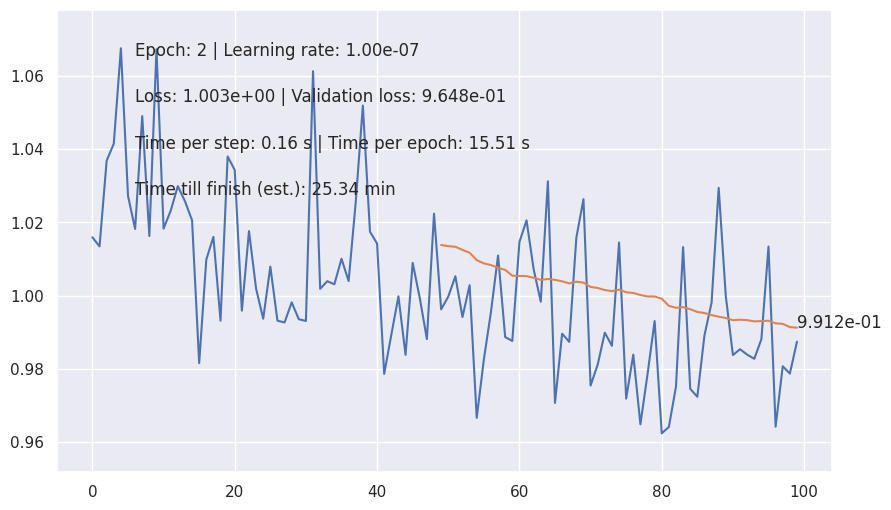

In [152]:
train(
    diffusion_imputer,
    # balanced_train_loader,
    train_dataloader,
    val_dataloader,
    num_gpus=1,
    batch_embedder=None,
    gradient_clip=1,
    device="cuda",
    epochs=100,
    lr=1e-7,
    explode=False,
    annealing_mode=False,
    annealing_window=2,
    annealing_multiplier=1.0,
    annealing_ratio=0.5,
    annealing_minimum=1e-7,
    loss_func=diffusion_imputer.loss_func,
    weighted_loss_func=diffusion_imputer.weighted_loss_func,
    validation_frequency=1,
    validation_prp=100,
    verbose=False,
    plot_every=5,
    # projection_horizon=2,
    moving_avg_window=50,
    plot_display_window=100
)

In [ ]:
# # save the entire model for further training
# torch.save(diffusion_imputer, "results/diffusion_imputer_cancer_feb16.pt")
# torch.save(data_embedder, "data_embedder_cancer_aug9.pt")

# Evaluation


In [131]:
import torch


def calculate_quantiles(imputed_samples_tensor, qlist):
    quantiles_imp = []
    for q in qlist:
        quantiles = torch.quantile(
            imputed_samples_tensor, q, dim=0, interpolation="midpoint"
        )
        quantiles_imp.append(quantiles)
    return torch.stack(quantiles_imp, dim=0)


# Calculate RMSE with denormalization


def calculate_rmse(
    final_samples, training_mean, training_std, qlist=[
        0.05, 0.25, 0.50, 0.75, 0.95],
    norm_const=1150.3465099894624
):
    all_data = []
    all_imputed = []
    imputed_samples_list = []
    actual_data_list = []

    # Extract one instance of the actual data and imputation mask
    data_instance, imputation_mask_instance = None, None
    sample_number = len(final_samples)

    for sample in final_samples:
        for imputed_samples, data, imputation_mask, _ in sample:
            # Store imputed samples for quantile calculation
            imputed_samples_list.append(
                imputed_samples[imputation_mask != 0].cpu())
            actual_data_list.append(data[imputation_mask != 0].cpu())
            # Flatten the tensors and filter non-zero mask areas
            all_data.append(data[imputation_mask != 0].cpu())
            all_imputed.append(imputed_samples[imputation_mask != 0].cpu())

    # Concatenate all filtered elements
    all_data = torch.cat(all_data)
    all_imputed = torch.cat(all_imputed)

    # Concatenate all imputed samples and reshape to original dimensions
    imputed_samples_tensor = torch.cat(
        imputed_samples_list).reshape(sample_number, -1)

    # Concatenate all actual data and reshape to original dimensions
    actual_data_tensor = torch.cat(actual_data_list).reshape(sample_number, -1)
    actual_data_tensor = actual_data_tensor[0]

    # Denormalize the data
    all_data = all_data * training_std + training_mean
    all_imputed = all_imputed * training_std + training_mean

    # Calculate RMSE for all imputed values
    rmse = torch.sqrt(torch.mean((all_data - all_imputed) ** 2)).item()
    rmse = rmse / norm_const * 100  # Adjust the RMSE as per your requirement

    # Calculate quantiles
    quantiles_imp = calculate_quantiles(imputed_samples_tensor, qlist)
    medians = quantiles_imp[qlist.index(0.50)]  # Median is the 50th percentile

    # Denormalize the medians
    medians = medians * training_std + training_mean

    # Use the median for the new RMSE calculation
    actual_data_tensor = actual_data_tensor * training_std + training_mean

    # Calculate RMSE with medians
    rmse_median = torch.sqrt(torch.mean(
        (actual_data_tensor - medians) ** 2)).item()
    # Adjust the RMSE as per your requirement
    rmse_median = rmse_median / norm_const * 100

    return rmse, rmse_median

In [132]:
def run_multiple_evaluations(
    dataloader,
    imputer,
    training_mean,
    training_std,
    sample_number,
    batch_embedder=None,
    old_sample=[],
    min_sequence_len=2,
    max_sequence_len=None,
    scale=1,
    verbose=True,
    show_max_diff=False,
    show_rmse=False,
):
    final_samples = old_sample
    max_seq_len = 0
    total_batches = len(dataloader) * sample_number
    completed_batches = 0
    sample_time = []
    average_sample_time = 0

    for i in range(sample_number):
        sample_start = time.time()
        # print a line to separate the samples
        print("-------------------------------------------------")
        print(f"Running sample {i + 1}/{sample_number}")
        all_samples = []
        for batch_idx, batch in enumerate(dataloader):
            # Get the data from the batch (collate_fn returns a tuple)
            sequence_lengths = batch['sequence_lengths']
            for key in batch.keys():
                batch[key] = batch[key][sequence_lengths >= min_sequence_len]
            sequence_lengths = batch['sequence_lengths']
            if max_sequence_len is not None:
                for key in batch.keys():
                    batch[key] = batch[key][sequence_lengths <= max_sequence_len]
                sequence_lengths = batch['sequence_lengths']
            imputer.sequence_length = sequence_lengths

            curr_treatments = batch['current_treatments']
            vitals_or_prev_outputs = []
            # vitals_or_prev_outputs.append(batch['vitals']) if self.has_vitals else None
            # if self.autoregressive else None
            vitals_or_prev_outputs.append(batch['prev_outputs'])
            vitals_or_prev_outputs = torch.cat(vitals_or_prev_outputs, dim=-1)
            static_features = batch['static_features']
            outputs = batch['outputs'][:, :, 1:2]

            batch = torch.cat(
                (vitals_or_prev_outputs, curr_treatments), dim=-1)
            batch = torch.cat((batch, static_features.unsqueeze(
                1).expand(-1, batch.size(1), -1)), dim=-1)
            batch = torch.cat((batch, outputs), dim=-1)
            # select the entries in the batch that have more than min_sequence_len
            # batch = batch[sequence_lengths >= min_sequence_len]
            batch = batch.to(imputer.device)
            # if batch_embedder is not None:
            #     batch = batch_embedder(batch)
            # seq_length = batch.shape[1]
            # if seq_length < min_sequence_len:
            #     # print(f"Skipping batch {batch_idx + 1} as sequence length is less than {min_sequence_len}")
            #     completed_batches += 1
            #     continue
            # if max_sequence_len is not None and seq_length > max_sequence_len:
            #     # print(f"Skipping batch {batch_idx + 1} as sequence length is greater than {max_sequence_len}")
            #     completed_batches += 1
            #     continue

            # print(f"sequence length: {sequence_lengths}")

            # Generate imputation masks for the current batch
            imputation_masks = imputer.get_mask(
                batch, strategy="selected_features_last_n_sequence_length"
            ).to(imputer.device)
            imputer.features_to_impute = [6]
            imputer.last_n_time = 1
            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    imputed_samples = imputer.eval(
                        batch,
                        imputation_masks,
                        mean=training_mean,
                        std=training_std,
                        scale=scale,
                        verbose=verbose,
                        show_max_diff=show_max_diff,
                        show_rmse=show_rmse,
                    )

            all_samples.append(imputed_samples)

            completed_batches += 1
            progress = completed_batches / total_batches
            print(f"Overall Progress: {progress * 100:.2f}%")
            print(
                f"Time to finish (est.): {average_sample_time * (sample_number - i - 1) / 60:.2f} min"
            )

        sample_end = time.time()
        sample_time.append(sample_end - sample_start)
        average_sample_time = sum(sample_time) / len(sample_time)
        final_samples.append(all_samples)

        rmse, rmse_median = calculate_rmse(
            final_samples, training_mean, training_std)
        print(f"RMSE: {rmse:.3f} | RMSE (Median): {rmse_median:.3f}")

    return final_samples

In [133]:
# diffusion_imputer = torch.load("diffusion_imputer_cancer_jul23.pt")
# data_embedder = torch.load("data_embedder_cancer_jul23.pt")

In [134]:
test_dataloader = DataLoader(
    weighted_causal_diff.dataset_collection.test_cf_one_step, batch_size=1000, shuffle=False)

for i, batch in enumerate(test_dataloader):
    if i == 0:
        print("Test batch")
        for key in batch.keys():
            print(key, batch[key].shape)
    else:
        break

Test batch
cancer_volume torch.Size([1000, 60])
chemo_application torch.Size([1000, 60])
radio_application torch.Size([1000, 60])
sequence_lengths torch.Size([1000])
patient_types torch.Size([1000])
median_cancer_volume torch.Size([1000, 60])
cancer_volume_5th_percentile torch.Size([1000, 60])
cancer_volume_95th_percentile torch.Size([1000, 60])
prev_treatments torch.Size([1000, 59, 4])
current_treatments torch.Size([1000, 59, 4])
current_covariates torch.Size([1000, 59, 2])
outputs torch.Size([1000, 59, 4])
active_entries torch.Size([1000, 59, 1])
unscaled_outputs torch.Size([1000, 59, 4])
prev_outputs torch.Size([1000, 59, 1])
static_features torch.Size([1000, 1])


In [135]:
training_mean = weighted_causal_diff.dataset_collection.train_f.scaling_params[
    'output_means']
training_standard_deviation = weighted_causal_diff.dataset_collection.train_f.scaling_params[
    'output_stds']

print("Training Mean:", training_mean)
print("Training Standard Deviation:", training_standard_deviation)

Training Mean: 7.734152322128
Training Standard Deviation: 52.43550990660674


In [136]:
import gc

torch.cuda.empty_cache()
gc.collect()

3375

In [137]:
# # change working directory
# os.chdir("/work/postresearch/Shared/Researchers/Farbod/cancer/")
# sys.path.append(os.getcwd())

In [138]:
sample_number = 10
final_samples = run_multiple_evaluations(
    dataloader=test_dataloader,
    imputer=diffusion_imputer,
    batch_embedder=None,
    training_mean=training_mean,
    training_std=training_standard_deviation,
    old_sample=[],  # final_samples,
    min_sequence_len=10,
    max_sequence_len=59,
    sample_number=sample_number,
    scale=1,
    show_rmse=True
)

-------------------------------------------------
Running sample 1/10
mae =  186.6704097808329
rmse =  1076.9489426760008
Overall Progress: 0.43%
Time to finish (est.): 0.00 min
mae =  170.17050669802052
rmse =  989.5343962860727
Overall Progress: 0.87%
Time to finish (est.): 0.00 min
mae =  172.94359956326267
rmse =  1002.2400928798012
Overall Progress: 1.30%
Time to finish (est.): 0.00 min


KeyboardInterrupt: 

In [ ]:
# save the final samples
# torch.save(final_samples, "final_samples_cancer_Feb16.pt")
# final_samples = torch.load("final_samples_cancer_jul20.pt")

In [473]:
len(final_samples)

10

In [474]:
# Calculate RMSE
rmse, rmse_median = calculate_rmse(
    final_samples, training_mean, training_standard_deviation
)
print(f"RMSE: {rmse}")
print(f"RMSE using median: {rmse_median}")

RMSE: 3.267792985616352
RMSE using median: 2.9637160596695797


In [ ]:
# def quantile_loss(target, forecast, q: float, eval_points) -> float:
#     return 2 * torch.sum(
#         torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
#     )


# def calc_denominator(target, eval_points):
#     return torch.sum(torch.abs(target * eval_points))


# def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
#     target = target * scaler + mean_scaler
#     forecast = forecast * scaler + mean_scaler

#     quantiles = np.arange(0.05, 1.0, 0.05)
#     denom = calc_denominator(target, eval_points)
#     CRPS = 0
#     for i in range(len(quantiles)):
#         q_pred = []
#         for j in range(len(forecast)):
#             q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
#         q_pred = torch.cat(q_pred, 0)
#         q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
#         CRPS += q_loss / denom
#     return CRPS.item() / len(quantiles)

In [ ]:
# sample_number = 100

In [ ]:
# all_target = samples[0][1]  # input_data same for all samples (B, L, K)
# all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
# all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
# CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, training_mean, training_standard_deviation)
# print(CRPS)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
# L = test_data.shape[1]
# K = test_data.shape[2]

# dataind = 40  # Number of samples to visualize
# start_time = 40
# n_skip = 0  # Number of columns to skip

# plt.rcParams["font.size"] = 16
# fig, axes = plt.subplots(nrows=dataind, ncols=K - n_skip, figsize=(24.0, 6 * dataind))

# for i in range(dataind):
#     for k in range(n_skip, K):  # Start from n_skip instead of 0
#         df = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": eval_points[i, start_time:, k]
#         })
#         df = df[df.y != 0]
#         df2 = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": given_points[i, start_time:, k]
#         })
#         df2 = df2[df2.y != 0]
#         indices = df.x.astype(int).to_numpy()
#         row = i
#         col = k - n_skip  # Adjust column index for skipped columns

#         axes[row][col].plot(range(start_time, L), quantiles_imp[2][i, start_time:, k], color='g', linestyle='solid', label='median')
#         axes[row][col].fill_between(range(start_time, L), quantiles_imp[0][i, start_time:, k], quantiles_imp[4][i, start_time:, k], color='g', alpha=0.3)
#         axes[row][col].plot(df.x, df.val, color='b', marker='o', linestyle='None')
#         axes[row][col].plot(df.x, quantiles_imp[5][i, indices, k], color='r', linestyle='None', label='median', marker='x')
#         axes[row][col].plot(df.x, quantiles_imp[0][i, indices, k], color='r', linestyle='None', marker=1)
#         axes[row][col].plot(df.x, quantiles_imp[4][i, indices, k], color='r', linestyle='None', marker=1)

#         if col == 0:  # Only label the first of the remaining columns
#             axes[row][col].set_ylabel('Value')
#         if row == dataind - 1:  # Only label the last row
#             axes[row][col].set_xlabel('Time')

# # Optional: Adjust the layout for better spacing
# plt.tight_layout()
# plt.show()